# 03_Component2_Gap_Analysis.ipynb


## 1. Environment Setup & Imports


In [4]:
## 1. Environment Setup & Imports

import pandas as pd
import numpy as np
import nltk
import torch
from transformers import pipeline, AutoTokenizer, AutoModel
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns
import json
from joblib import load, dump

# Styling
sns.set(style="whitegrid")

# Download NLTK data (once)
nltk.download('punkt')
nltk.download('stopwords')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\piyum\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\piyum\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## 2. Load Data & Models


In [11]:
# 03_Component2_Gap_Analysis_TFIDF.ipynb

## 1. Environment Setup & Imports

import pandas as pd
import numpy as np
import nltk

# Sentiment
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Tokenization
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords

# TF-IDF & similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Utilities
from joblib import load, dump

# Styling
sns.set(style="whitegrid")

# Download required NLTK data (run once)
nltk.download('punkt')
nltk.download('vader_lexicon')
nltk.download('stopwords')


## 2. Load Data & Prepare Resources

# 2.1 Preprocessed feedback
df = pd.read_excel("cleaned_feedback_preprocessed.xlsx")

# 2.2 Inline Aspect Ontology
ontology = {
    "mentorship": ["mentor","supervisor","coach","guide","mentorship"],
    "technical_support": ["code","review","debug","assistance","support","ci_cd","repository","documentation"],
    "learning_opportunities": ["training","workshop","tutorial","learning","session","seminar"],
    "workload": ["task","deadline","hours","workload","assignment","responsibility"],
    "team_collaboration": ["team","communication","meeting","collaboration","scrum","stand_up"],
    "environment": ["workspace","tools","software","hardware","remote","office","infrastructure"],
    "professional_networking": ["networking","event","culture","social","interaction","community"],
    "career_guidance": ["career","path","feedback","evaluation","progression","review"]
}
aspect_categories = list(ontology.keys())

# 2.3 Sentiment analyzer
sid = SentimentIntensityAnalyzer()

# 2.4 Stopwords for token filtering
stop_words = set(stopwords.words('english'))
# (Add any domain‐specific stopwords if desired)


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\piyum\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\piyum\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\piyum\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 3. Helper Functions


In [38]:
## 3. Helper Functions (NLTK‐free tokenization)

import re
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# initialize sentiment analyzer
sid = SentimentIntensityAnalyzer()

def split_sentences(text: str) -> list[str]:
    """
    Split text on '.', '!' or '?' followed by whitespace.
    Returns non-empty trimmed segments.
    """
    parts = re.split(r'(?<=[.!?])\s+', text)
    return [p.strip() for p in parts if p.strip()]

def classify_sentence_type(sent: str) -> str:
    """
    Heuristic to classify a sentence as:
      - "expect" if it mentions expectation keywords,
      - "experience" if it mentions experience keywords,
      - "other" otherwise.
    """
    s = sent.lower()
    if re.search(r'\b(expect|hope|plan|anticipat|want)\b', s):
        return "expect"
    if re.search(r'\b(found|was|experienced|learned|got|felt)\b', s):
        return "experience"
    return "other"

def map_aspects(sent: str) -> list[str]:
    """
    Return list of aspect categories whose lexicon terms appear in the sentence.
    Tokenization is done via simple regex.
    """
    tokens = re.findall(r'\b[a-zA-Z]+\b', sent.lower())
    cats = []
    for aspect, terms in ontology.items():
        for term in terms:
            if term in tokens:
                cats.append(aspect)
                break
    return cats

def sentiment_polarity(sent: str) -> int:
    """
    Compute VADER compound score and map to {-1,0,+1}.
    """
    score = sid.polarity_scores(sent)["compound"]
    if score >= 0.05:
        return 1
    if score <= -0.05:
        return -1
    return 0


## 4. Build Expectation & Experience Sets


In [39]:
## 4. Build Expectation & Experience Records (corrected)

# 4.1 Auto‐detect the main feedback column by average string length
string_cols = df.select_dtypes(include='object').columns
avg_lengths = (
    df[string_cols]
    .dropna()
    .astype(str)
    .applymap(len)
    .mean()
)
text_col = avg_lengths.idxmax()
print(f"Using `{text_col}` as the feedback text column.\n")

# 4.2 Build the records list
records = []
for idx, text in df[text_col].dropna().astype(str).items():   # use .items() instead of iteritems()
    # split into sentences
    for sent in split_sentences(text):
        sent_type = classify_sentence_type(sent)
        if sent_type == "other":
            continue
        cats = map_aspects(sent)
        if not cats:
            continue
        pol = sentiment_polarity(sent)
        records.append({
            "id": idx,
            "sentence": sent,
            "sent_type": sent_type,
            "aspects": cats,
            "polarity": pol
        })

gap_df = pd.DataFrame(records)

# 4.3 Inspect results
print("Sentence type counts:\n", gap_df["sent_type"].value_counts())
print("\nColumns in gap_df:", gap_df.columns.tolist())


Using `unnamed__7` as the feedback text column.

Sentence type counts:
 sent_type
experience    32
expect         3
Name: count, dtype: int64

Columns in gap_df: ['id', 'sentence', 'sent_type', 'aspects', 'polarity']


C:\Users\piyum\AppData\Local\Temp\ipykernel_22688\625436299.py:6: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df[string_cols]


## 5. Compute Per-Aspect Metrics per Intern


In [40]:
## 5. Compute Per-Aspect Discrepancy Metrics

from sklearn.feature_extraction.text import TfidfVectorizer

# 5.1 Fit TF-IDF on all extracted sentences
tfidf = TfidfVectorizer()
tfidf.fit(gap_df['sentence'])

res = []
alpha = 0.6  # semantic vs. sentiment weight

for idx, grp in gap_df.groupby('id'):
    # overall satisfaction if available
    overall = df.at[idx, 'overall_satisfaction'] if 'overall_satisfaction' in df.columns else np.nan

    for aspect in aspect_categories:
        sub = grp[grp['aspects'].apply(lambda L: aspect in L)]

        # Expectation sentences
        exp_sents = sub[sub['sent_type']=='expect']['sentence'].tolist()
        if exp_sents:
            exp_mat = tfidf.transform(exp_sents)
            exp_cent = np.asarray(exp_mat.mean(axis=0)).ravel()
            exp_pol = sub[sub['sent_type']=='expect']['polarity'].mean()
        else:
            exp_cent = np.zeros(tfidf.transform(['']).shape[1])
            exp_pol = 0.0

        # Experience sentences
        xp_sents = sub[sub['sent_type']=='experience']['sentence'].tolist()
        if xp_sents:
            xp_mat = tfidf.transform(xp_sents)
            xp_cent = np.asarray(xp_mat.mean(axis=0)).ravel()
            xp_pol = sub[sub['sent_type']=='experience']['polarity'].mean()
        else:
            xp_cent = np.zeros(tfidf.transform(['']).shape[1])
            xp_pol = 0.0

        # Semantic gap
        sim = cosine_similarity([exp_cent], [xp_cent])[0, 0]
        sem_gap = 1 - sim

        # Sentiment gap
        sent_gap = xp_pol - exp_pol

        # Hybrid gap
        hyb_gap = alpha * sem_gap + (1 - alpha) * abs(sent_gap)

        res.append({
            'id': idx,
            'aspect': aspect,
            'exp_mean_pol': exp_pol,
            'xp_mean_pol': xp_pol,
            'semantic_gap': sem_gap,
            'sentiment_gap': sent_gap,
            'hybrid_gap': hyb_gap,
            'overall_satisfaction': overall
        })

metrics_df = pd.DataFrame(res)
metrics_df.head()


,id,aspect,exp_mean_pol,xp_mean_pol,semantic_gap,sentiment_gap,hybrid_gap,overall_satisfaction
0,5,mentorship,0.0,0.0,1.0,0.0,0.6,NaN
1,5,technical_support,0.0,0.0,1.0,0.0,0.6,NaN
2,5,learning_opportunities,0.0,0.0,1.0,0.0,0.6,NaN
3,5,workload,0.0,1.0,1.0,1.0,1.0,NaN
4,5,team_collaboration,0.0,0.0,1.0,0.0,0.6,NaN


## 6. Visualizations


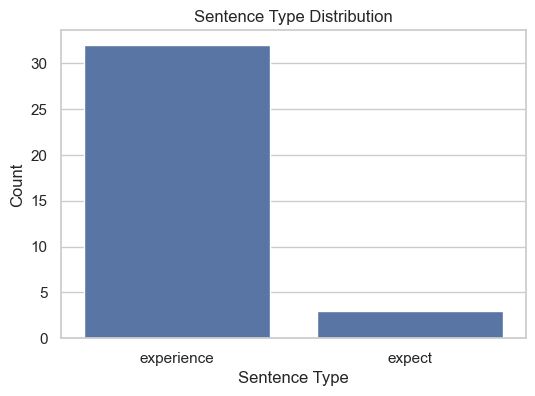

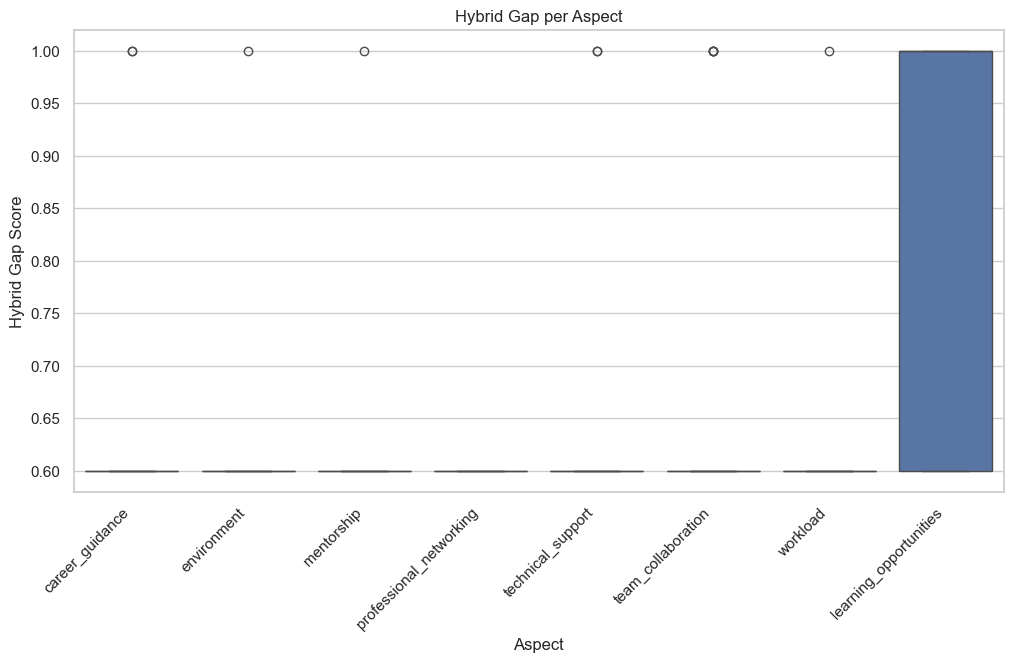

Pearson correlation (overall_satisfaction vs. hybrid_gap): nan


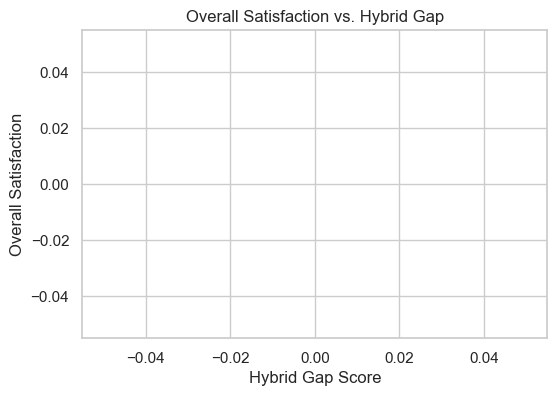

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

# 6.1 Sentence Type Distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='sent_type', data=gap_df, order=gap_df['sent_type'].value_counts().index)
plt.title("Sentence Type Distribution")
plt.xlabel("Sentence Type")
plt.ylabel("Count")
plt.show()

# 6.2 Hybrid Gap Boxplot per Aspect
plt.figure(figsize=(12, 6))
sns.boxplot(x='aspect', y='hybrid_gap', data=metrics_df, order=metrics_df.groupby('aspect')['hybrid_gap'].median().sort_values().index)
plt.title("Hybrid Gap per Aspect")
plt.xlabel("Aspect")
plt.ylabel("Hybrid Gap Score")
plt.xticks(rotation=45, ha='right')
plt.show()

# 6.3 Correlation Between Overall Satisfaction and Hybrid Gap
if 'overall_satisfaction' in metrics_df.columns:
    corr = metrics_df['hybrid_gap'].corr(metrics_df['overall_satisfaction'])
    print(f"Pearson correlation (overall_satisfaction vs. hybrid_gap): {corr:.2f}")

    plt.figure(figsize=(6, 4))
    sns.scatterplot(x='hybrid_gap', y='overall_satisfaction', data=metrics_df, alpha=0.4)
    plt.title("Overall Satisfaction vs. Hybrid Gap")
    plt.xlabel("Hybrid Gap Score")
    plt.ylabel("Overall Satisfaction")
    plt.show()
else:
    print("Column 'overall_satisfaction' not found in metrics_df.")


## 7. Save Metrics & Models


In [35]:
# save results
metrics_df.to_excel("gap_analysis_metrics.xlsx", index=True)
# (optional) save alpha for later
dump(alpha, "models/hybrid_gap_alpha.joblib")


['models/hybrid_gap_alpha.joblib']